## Create the dataset

In [ ]:
import os
from tqdm import tqdm

First, lets check what folders and files we have, each folder name represents a (genre)

In [ ]:
genre_path = 'drive/MyDrive/Colab Notebooks/archive/genre/'
file_path = [os.path.join(genre_path,x) for x in os.listdir(genre_path) if "." not in x]
genres = [x for x in os.listdir(genre_path)]

Secondly, we will list the files inside the folders and we will append it to a 2D array, with the filepath of each song and the label (genre) value

In [ ]:
audio_paths = []
for gener, i in zip(genres,tqdm(file_path)):
    for j in os.listdir(i):
        file = os.path.join(i,j)
        audio_paths.append([file,gener])

100%|██████████| 2/2 [00:00<00:00, 97.54it/s]


Now, lets convert the 2D array to a pandas dataframe in order to do it faster and simpler

In [ ]:
import pandas as pd
df = pd.DataFrame(audio_paths, columns=['File', 'Genre'])
df

,File,Genre
0,drive/MyDrive/Colab Notebooks/archive/genre/ro...,rock
1,drive/MyDrive/Colab Notebooks/archive/genre/ro...,rock
2,drive/MyDrive/Colab Notebooks/archive/genre/ro...,rock
3,drive/MyDrive/Colab Notebooks/archive/genre/ro...,rock
4,drive/MyDrive/Colab Notebooks/archive/genre/ro...,rock
...,...,...
392,drive/MyDrive/Colab Notebooks/archive/genre/cl...,classical
393,drive/MyDrive/Colab Notebooks/archive/genre/cl...,classical
394,drive/MyDrive/Colab Notebooks/archive/genre/cl...,classical
395,drive/MyDrive/Colab Notebooks/archive/genre/cl...,classical


## Data exploration

In [ ]:
import librosa
from IPython.display import Audio

classic_example= df[df["Genre"]=="classical"]. iloc[0]
classic_example_data , classic_example_sr = librosa.load(classic_example["File"])

rock_example= df[df["Genre"]=="rock"]. iloc[0]
rock_example_data , rock_example_sr = librosa.load(rock_example["File"])

In [ ]:
Audio(data=classic_example_data, rate=classic_example_sr)

In [ ]:
Audio(data=rock_example_data, rate=rock_example_sr)

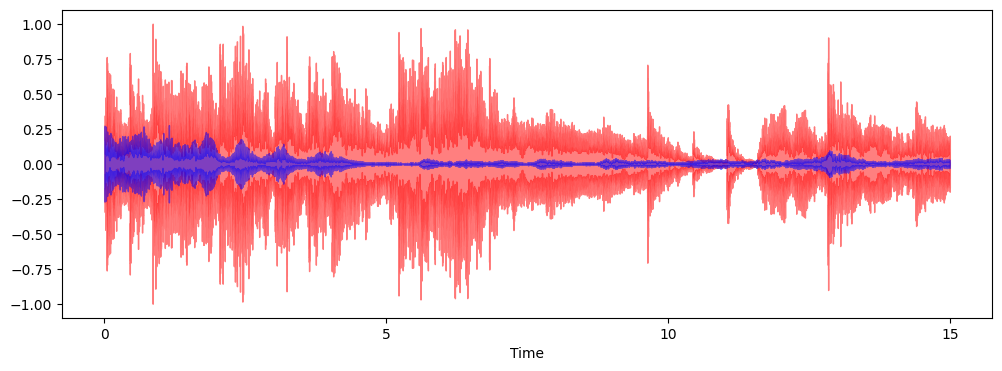

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(12, 4))
librosa.display.waveshow(rock_example_data, color='r',alpha=0.5)
librosa.display.waveshow(classic_example_data,color='b',alpha=0.5)
plt.show()

by taking a simple look, disco looks like it have higher amplitud values

### Frequency domain

Text(0, 0.5, 'Amplitude')

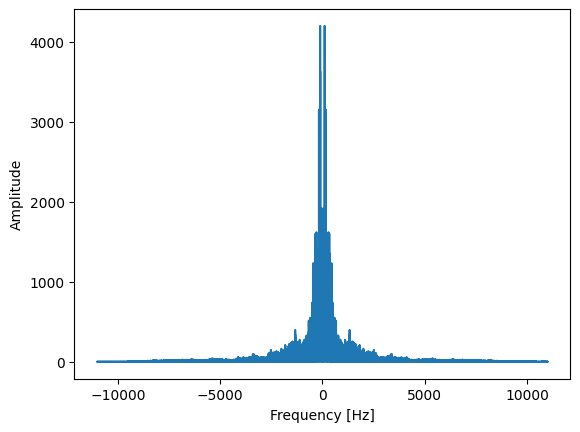

In [ ]:
import numpy as np

rock_f = np.abs(np.fft.fft(rock_example_data))
freq_steps = np.fft.fftfreq(rock_example_data.size, d=1/rock_example_sr)
plt.figure()
plt.plot(freq_steps, rock_f)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

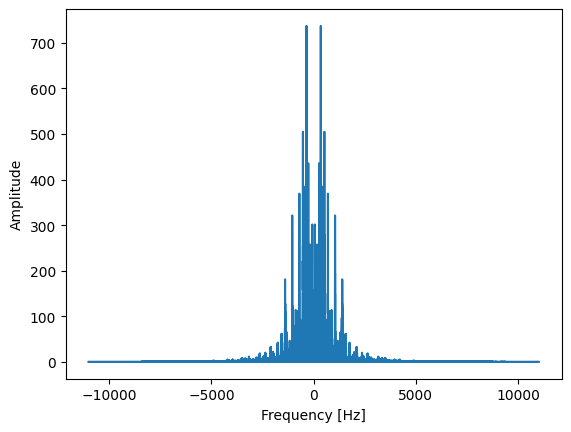

In [ ]:
classical_f = np.abs(np.fft.fft(classic_example_data))
freq_steps = np.fft.fftfreq(classic_example_data.size, d=1/classic_example_sr)
plt.figure()
plt.plot(freq_steps, classical_f)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")

In [ ]:
from scipy import stats
stats.describe(rock_f)

DescribeResult(nobs=330750, minmax=(0.013298871982906444, 4196.040632004645), mean=30.29251392024307, variance=7954.919023351203, skewness=11.303790840038609, kurtosis=242.96774672877095)

In [ ]:
stats.describe(classical_f)

DescribeResult(nobs=330750, minmax=(0.0004549714935530059, 736.9409723229959), mean=3.368347825464565, variance=253.92901865706668, skewness=15.274359970942408, kurtosis=368.05013527022913)

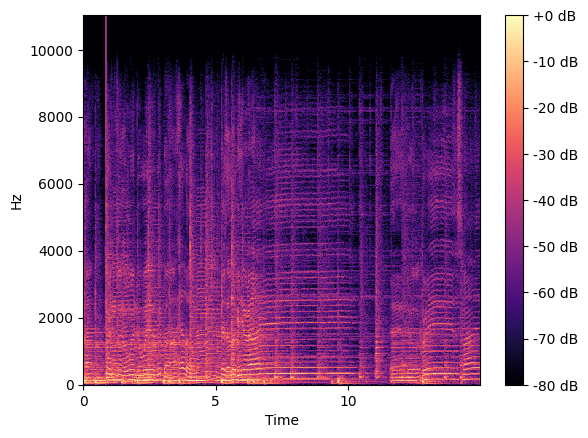

In [ ]:
D = librosa.stft(rock_example_data)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

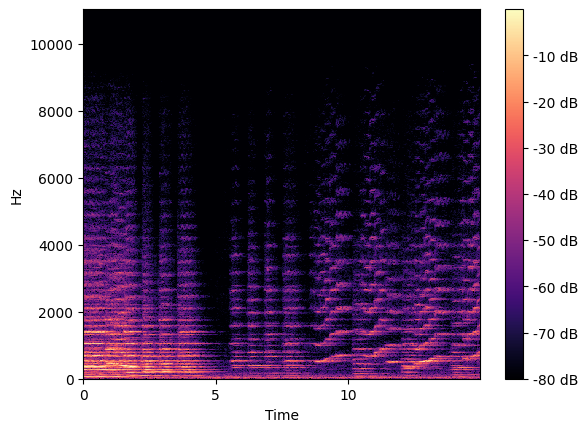

In [ ]:
D = librosa.stft(classic_example_data)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

## Feature extraction and dataset enrichment

### Time domain features

In [ ]:
def amplitude_envelope(signal, frame_size, window_size):
  return np.array([max(signal[i:i+frame_size]) for i in range(0, signal.size, window_size)])

In [ ]:
def extract_time_domain_features(path):
    ## get wave data
    song_data,_ = librosa.load(path)

    ## get as time series
    FRAME_SIZE = 1024
    WINDOW_SIZE = 128
    ae = amplitude_envelope(song_data,FRAME_SIZE,WINDOW_SIZE)
    rms = librosa.feature.rms(y=song_data, frame_length=FRAME_SIZE, hop_length=WINDOW_SIZE)[0]
    zcr = librosa.feature.zero_crossing_rate(song_data, frame_length=FRAME_SIZE, hop_length=WINDOW_SIZE)[0]

    ## aggregate with statistics
    ae_stats = stats.describe(ae)
    rms_stats = stats.describe(rms)
    zcr_stats = stats.describe(zcr)
    data_features_vector=[ae_stats.minmax[0],ae_stats.minmax[1],ae_stats.mean,ae_stats.variance,
                         rms_stats.minmax[0],rms_stats.minmax[1],rms_stats.mean,rms_stats.variance,
                         zcr_stats.minmax[0],zcr_stats.minmax[1],zcr_stats.mean,zcr_stats.variance]
    return data_features_vector

In [ ]:
extract_time_domain_features(classic_example["File"])

[0.0015563965,
 0.2758789,
 0.0477516,
 0.002557773696149775,
 0.0011843913,
 0.0924242,
 0.019210009,
 0.0004297492101188551,
 0.0009765625,
 0.173828125,
 0.060753978811919504,
 0.0009769715067611047]

### Building dataset

time domain

In [ ]:
df["time_vector"] = df["File"].apply(extract_time_domain_features)

In [ ]:
df = df.assign(
    min_ae = df["time_vector"].apply(lambda x : x[0]),
    max_ae = df["time_vector"].apply(lambda x : x[1]),
    mean_ae = df["time_vector"].apply(lambda x : x[2]),
    variance_ae = df["time_vector"].apply(lambda x : x[3]),
    min_rms = df["time_vector"].apply(lambda x : x[4]),
    max_rms = df["time_vector"].apply(lambda x : x[5]),
    mean_rms = df["time_vector"].apply(lambda x : x[6]),
    variance_rms = df["time_vector"].apply(lambda x : x[7]),
    min_zcr = df["time_vector"].apply(lambda x : x[8]),
    max_zcr = df["time_vector"].apply(lambda x : x[9]),
    mean_zcr = df["time_vector"].apply(lambda x : x[10]),
    variance_zcr = df["time_vector"].apply(lambda x : x[11]),
)

df = df.drop("time_vector",axis="columns")

frequency domain

In [ ]:
def extract_freq_domain_features(path):
  song_data,_ = librosa.load(path)
  fq = np.abs(np.fft.fft(song_data))
  fq_stats = stats.describe(fq)
  return [fq_stats.minmax[0],fq_stats.minmax[1],fq_stats.mean,fq_stats.variance]

In [ ]:
df["freq_vector"] = df["File"].apply(extract_freq_domain_features)

In [ ]:
df = df.assign(
    min_fq = df["freq_vector"].apply(lambda x : x[0]),
    max_fq = df["freq_vector"].apply(lambda x : x[1]),
    mean_fq = df["freq_vector"].apply(lambda x : x[2]),
    variance_fq = df["freq_vector"].apply(lambda x : x[3])
)
df = df.drop("freq_vector",axis="columns")
df = df.drop("File",axis="columns")

In [ ]:
df

,Genre,min_ae,max_ae,mean_ae,variance_ae,min_rms,max_rms,mean_rms,variance_rms,min_zcr,max_zcr,mean_zcr,variance_zcr,min_fq,max_fq,mean_fq,variance_fq
0,rock,0.021484,0.969177,0.391205,0.047551,0.007442,0.371322,0.145568,0.005627,0.008789,0.367188,0.056065,0.001282,0.013299,4196.040632,30.292514,7954.919023
1,rock,0.052460,0.747620,0.258065,0.022786,0.018937,0.268490,0.088135,0.002892,0.009766,0.306641,0.086647,0.002091,0.001194,2042.998578,23.514390,2973.920805
2,rock,0.256317,0.999603,0.563276,0.022203,0.102668,0.398523,0.204698,0.003241,0.025391,0.162109,0.079912,0.000423,0.017373,5306.813773,46.534110,12780.200101
3,rock,0.125885,0.968811,0.448416,0.034377,0.051017,0.379002,0.175832,0.004221,0.015625,0.367188,0.052860,0.001749,0.000867,3470.769870,34.478800,10444.302520
4,rock,0.184052,0.882446,0.502182,0.016334,0.095418,0.342045,0.227130,0.001575,0.007812,0.319336,0.044547,0.001868,0.000454,5054.460361,40.362792,15962.433770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,classical,0.019867,0.348907,0.098019,0.003108,0.007696,0.123872,0.034432,0.000394,0.028320,0.210938,0.071471,0.001045,0.000655,711.018981,8.310189,453.455093
393,classical,0.018097,0.112335,0.039365,0.000232,0.006529,0.053576,0.015713,0.000046,0.018555,0.083984,0.046523,0.000102,0.000133,347.338821,1.856164,93.363133
394,classical,0.020538,0.283936,0.103758,0.001821,0.008164,0.092055,0.037340,0.000232,0.036133,0.179688,0.076456,0.000533,0.002253,990.509616,7.962603,475.555588
395,classical,0.011078,0.181061,0.051166,0.000681,0.004032,0.058732,0.018582,0.000088,0.017578,0.133789,0.064584,0.000368,0.000697,378.081455,3.995727,127.541671


In [ ]:
df.to_csv('drive/MyDrive/Colab Notebooks/archive/genre/features.csv',index=False)